In [11]:
#Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam



In [7]:
# Загрузка данных
df = pd.read_csv("/content/Market_Trend_External.csv")

# Просмотр первых строк
df.head()



,Date,Open_Price,Close_Price,High_Price,Low_Price,Volume,Daily_Return_Pct,Volatility_Range,VIX_Close,Economic_News_Flag,Sentiment_Score,Federal_Rate_Change_Flag,GeoPolitical_Risk_Score,Currency_Index
0,1902-09-08,100.00,100.50,100.63,99.35,2334489,0.0000,1.28,31.44,0,-0.413,0,61.60,98.88
1,1902-09-09,100.50,102.02,102.30,99.49,10626850,1.5124,2.81,27.99,1,-0.384,1,69.49,93.43
2,1902-09-10,102.02,101.55,102.56,101.09,9884633,-0.4607,1.47,21.27,1,0.591,0,67.41,84.25
3,1902-09-11,101.55,101.08,104.16,100.13,9405648,-0.4628,4.03,48.86,1,0.599,1,50.91,87.78
4,1902-09-12,101.08,98.65,101.69,98.39,5247581,-2.4040,3.30,15.78,1,-0.081,1,23.00,82.11


In [ ]:
#Общая информация о датасете
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      30000 non-null  object 
 1   Open_Price                30000 non-null  float64
 2   Close_Price               30000 non-null  float64
 3   High_Price                30000 non-null  float64
 4   Low_Price                 30000 non-null  float64
 5   Volume                    30000 non-null  int64  
 6   Daily_Return_Pct          30000 non-null  float64
 7   Volatility_Range          30000 non-null  float64
 8   VIX_Close                 30000 non-null  float64
 9   Economic_News_Flag        30000 non-null  int64  
 10  Sentiment_Score           30000 non-null  float64
 11  Federal_Rate_Change_Flag  30000 non-null  int64  
 12  GeoPolitical_Risk_Score   30000 non-null  float64
 13  Currency_Index            30000 non-null  float64
dtypes: flo

,Open_Price,Close_Price,High_Price,Low_Price,Volume,Daily_Return_Pct,Volatility_Range,VIX_Close,Economic_News_Flag,Sentiment_Score,Federal_Rate_Change_Flag,GeoPolitical_Risk_Score,Currency_Index
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,43.087641,43.085199,44.279328,41.904632,1.004296e+07,0.504709,2.380822,30.130952,0.501933,-0.002085,0.498900,49.969551,100.097362
std,29.359355,29.357668,29.367896,29.353710,5.727237e+06,11.266414,1.043352,11.539074,0.500005,0.579122,0.500007,28.860493,11.558390
min,1.000000,1.000000,1.020000,0.000000,1.016990e+05,-70.414200,0.070000,10.000000,0.000000,-1.000000,0.000000,0.000000,80.000000
25%,18.677500,18.677500,19.900000,17.440000,5.076650e+06,-1.765950,1.620000,20.140000,0.000000,-0.509000,0.000000,25.010000,90.130000
50%,38.580000,38.570000,39.770000,37.395000,1.004389e+07,0.000000,2.270000,30.140000,1.000000,0.002000,0.000000,49.835000,100.180000
75%,63.750000,63.742500,64.945000,62.530000,1.497032e+07,1.784200,3.030000,40.092500,1.000000,0.501000,1.000000,74.822500,110.160000
max,130.610000,130.610000,132.090000,130.140000,1.999982e+07,277.000000,7.960000,50.000000,1.000000,1.000000,1.000000,99.990000,120.000000


In [ ]:
# Преобразование даты и сортировка
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Интерполяция ценовых показателей
price_columns = ['Open_Price', 'Close_Price', 'High_Price', 'Low_Price']
df[price_columns] = df[price_columns].interpolate(method='linear')

# Заполнение пропусков в числовых признаках медианой
numeric_columns = [
    'Volume', 'Daily_Return_Pct', 'Volatility_Range',
    'VIX_Close', 'Sentiment_Score',
    'GeoPolitical_Risk_Score', 'Currency_Index'
]

df[numeric_columns] = df[numeric_columns].apply(
    lambda x: x.fillna(x.median())
)

# Заполнение пропусков в бинарных признаках модой
binary_columns = ['Economic_News_Flag', 'Federal_Rate_Change_Flag']

df[binary_columns] = df[binary_columns].apply(
    lambda x: x.fillna(x.mode()[0])
)

# Финальная проверка
df.isnull().sum()



,0
Date,0
Open_Price,0
Close_Price,0
High_Price,0
Low_Price,0
Volume,0
Daily_Return_Pct,0
Volatility_Range,0
VIX_Close,0
Economic_News_Flag,0


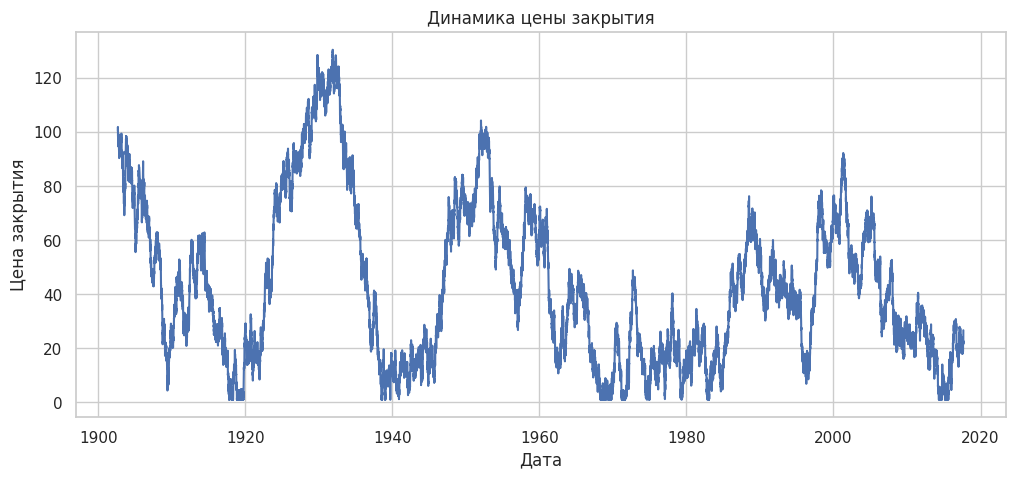

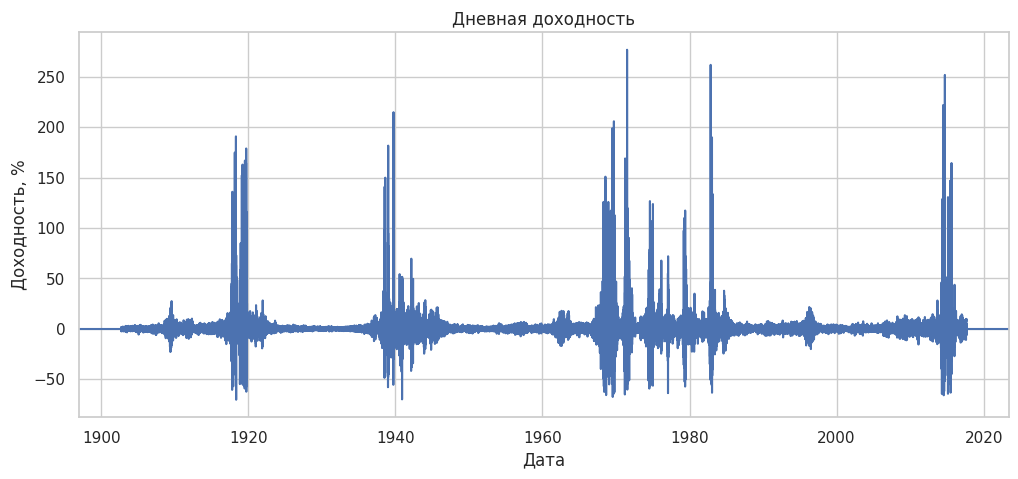

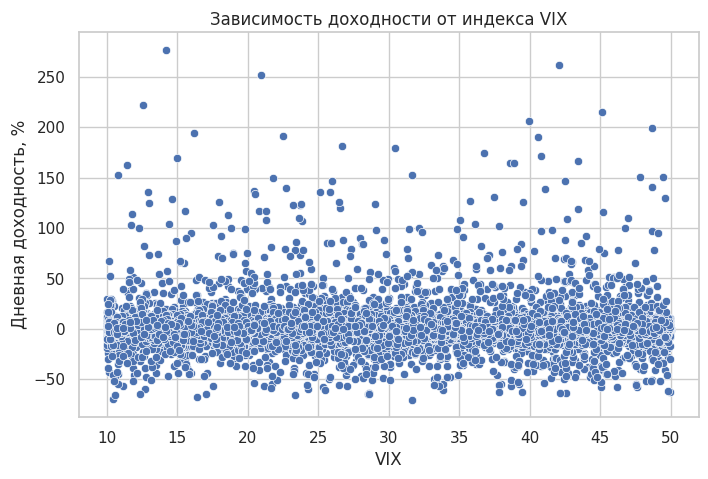

In [ ]:
#Визуализация данных
sns.set(style="whitegrid")
#Динамика цен закрытия
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close_Price'])
plt.title('Динамика цены закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

#Дневная доходность
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Daily_Return_Pct'])
plt.axhline(0)
plt.title('Дневная доходность')
plt.xlabel('Дата')
plt.ylabel('Доходность, %')
plt.show()

#Связь индекса VIX и доходности
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='VIX_Close',
    y='Daily_Return_Pct',
    data=df
)
plt.title('Зависимость доходности от индекса VIX')
plt.xlabel('VIX')
plt.ylabel('Дневная доходность, %')
plt.show()



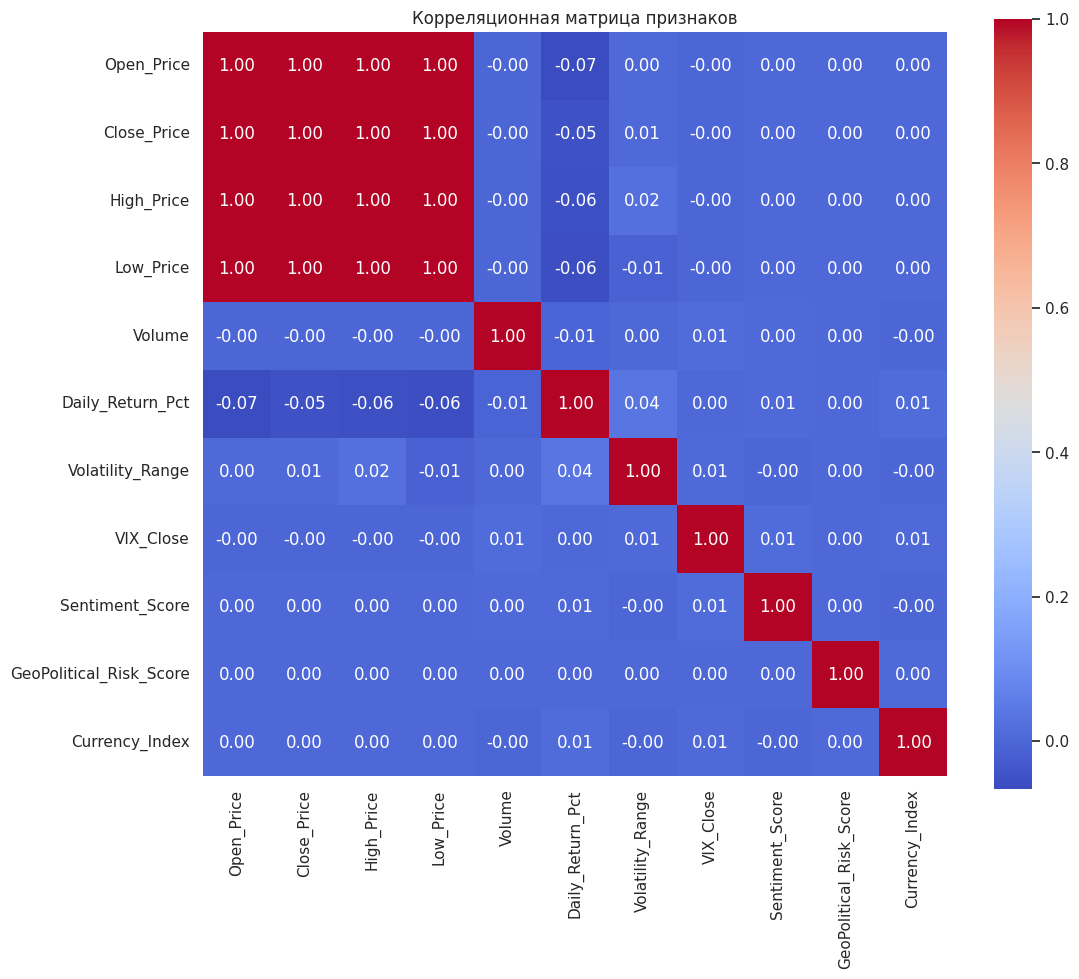

In [ ]:
# Отбираем только числовые признаки для корреляционного анализа
corr_features = [
    'Open_Price',
    'Close_Price',
    'High_Price',
    'Low_Price',
    'Volume',
    'Daily_Return_Pct',
    'Volatility_Range',
    'VIX_Close',
    'Sentiment_Score',
    'GeoPolitical_Risk_Score',
    'Currency_Index'
]

# Расчёт корреляционной матрицы (Пирсон)
corr_matrix = df[corr_features].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title('Корреляционная матрица признаков')
plt.show()

R2: 0.9989, MSE: 0.9841
   Open_Price  Actual_Close_Price  Predicted_Close_Price
0       38.78               37.91              38.777380
1       69.52               67.30              69.496219
2       41.82               42.04              41.815288
3       55.53               57.08              55.515850
4       51.93               52.66              51.918328
5       67.49               69.50              67.467617
6       29.26               27.49              29.263934
7      119.55              118.79             119.491780
8       26.27               24.74              26.275992
9       12.16               13.49              12.175705


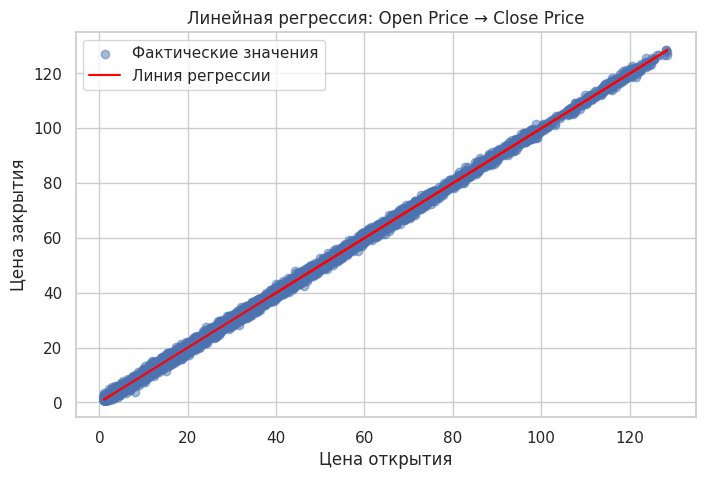

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Признак и целевая переменная
X = df[['Open_Price']]
y = df['Close_Price']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Обучение модели
model_price = LinearRegression()
model_price.fit(X_train, y_train)

# Прогноз
y_pred = model_price.predict(X_test)

# Метрики
r2_price = r2_score(y_test, y_pred)
mse_price = mean_squared_error(y_test, y_pred)

print(f"R2: {r2_price:.4f}, MSE: {mse_price:.4f}")

# Вывод фактических и предсказанных значений
results = pd.DataFrame({
    'Open_Price': X_test['Open_Price'],
    'Actual_Close_Price': y_test,
    'Predicted_Close_Price': y_pred
}).reset_index(drop=True)

print(results.head(10))  # покажем первые 10 строк, чтобы не засорять вывод

# График
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, alpha=0.5, label='Фактические значения')
plt.plot(X_test, y_pred, color='red', label='Линия регрессии')
plt.xlabel('Цена открытия')
plt.ylabel('Цена закрытия')
plt.title('Линейная регрессия: Open Price → Close Price')
plt.legend()
plt.show()



R2: 0.2354, MSE: 85.5253
       Open_Price  Close_Price  High_Price  Low_Price  Actual_Return  \
2308    -0.146724    -0.176284   -0.186919  -0.141539        -2.2434   
22404    0.900319     0.824834    0.879569   0.850856        -3.1933   
23397   -0.043177    -0.035603   -0.033007  -0.002883         0.5261   
25058    0.423802     0.476708    0.482531   0.406953         2.7913   
2664     0.301182     0.326149    0.292524   0.310200         1.4057   
8511     0.831175     0.899773    0.892509   0.846768         2.9782   
5148    -0.470987    -0.531223   -0.507683  -0.514241        -6.0492   
7790     2.604404     2.578749    2.597460   2.602623        -0.6357   
11311   -0.572830    -0.624897   -0.587363  -0.627006        -5.8241   
19043   -1.053434    -1.008108   -1.021858  -1.022874        10.9375   

       Predicted_Return  
2308          -4.617623  
22404        -11.686426  
23397          1.693500  
25058          9.360731  
2664           3.911581  
8511          11.398849  


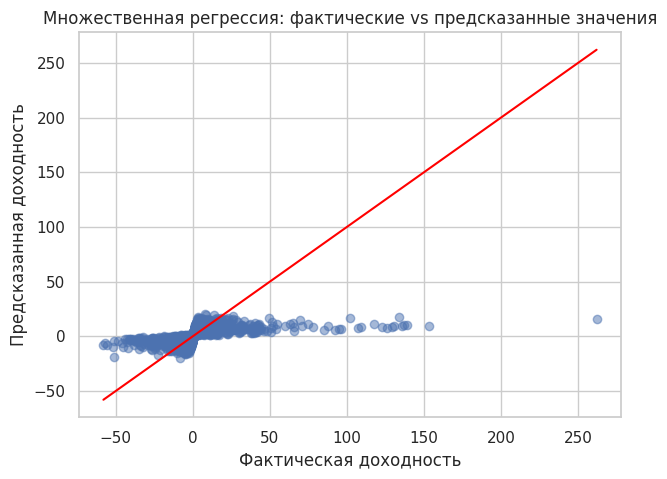

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Целевая переменная
y = df['Daily_Return_Pct']

# Выбираем только признаки с высокой корреляцией
X = df[['Open_Price', 'Close_Price', 'High_Price', 'Low_Price']]

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Обучение модели
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# Прогноз
y_pred = multi_model.predict(X_test)

# Метрики
r2_multi = r2_score(y_test, y_pred)
mse_multi = mean_squared_error(y_test, y_pred)

print(f"R2: {r2_multi:.4f}, MSE: {mse_multi:.4f}")

# Таблица фактических и предсказанных значений
results = pd.DataFrame({
    'Open_Price': X_test[:,0],
    'Close_Price': X_test[:,1],
    'High_Price': X_test[:,2],
    'Low_Price': X_test[:,3],
    'Actual_Return': y_test,
    'Predicted_Return': y_pred
})
print(results.head(10))

# Визуализация
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Фактическая доходность')
plt.ylabel('Предсказанная доходность')
plt.title('Множественная регрессия: фактические vs предсказанные значения')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()




Accuracy: 0.5090
Confusion Matrix:
[[3008    3]
 [2943   46]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      3011
           1       0.94      0.02      0.03      2989

    accuracy                           0.51      6000
   macro avg       0.72      0.51      0.35      6000
weighted avg       0.72      0.51      0.35      6000



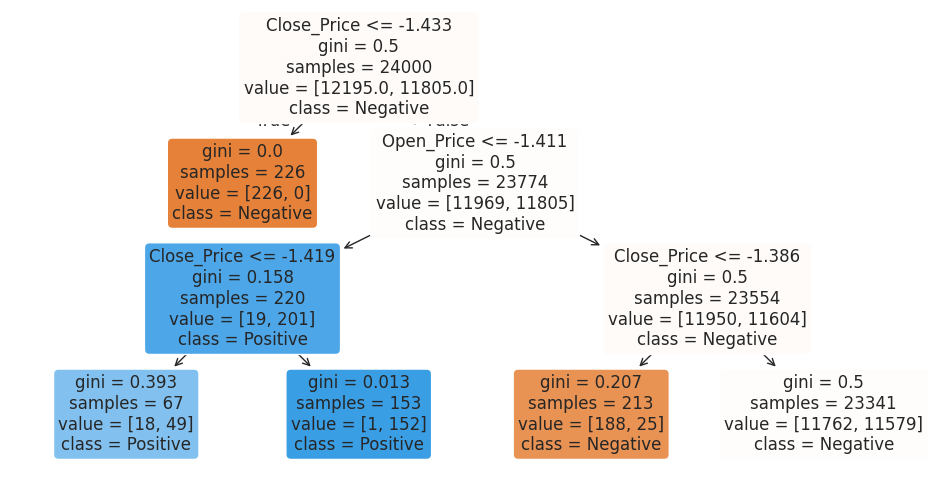

Feature Importances:
            Feature  Importance
0       Close_Price    0.696556
1        Open_Price    0.303444
2        High_Price    0.000000
3  Volatility_Range    0.000000
4   Sentiment_Score    0.000000


In [30]:
# Создание целевой переменной для классификации
df['Return_Direction'] = (df['Daily_Return_Pct'] > 0).astype(int)

# Выбираем топ-5 признаков для компактного дерева
top_features = ['Close_Price', 'Open_Price', 'High_Price', 'Volatility_Range', 'Sentiment_Score']
X = df[top_features]
y = df['Return_Direction']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Обучение дерева решений с ограниченной глубиной
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Прогноз
y_pred = tree_model.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Визуализация дерева через plot_tree
plt.figure(figsize=(12,6))
plot_tree(
    tree_model,
    feature_names=top_features,
    class_names=['Negative','Positive'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': top_features,
    'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance)

Accuracy: 0.5428
Confusion Matrix:
[[1644 1367]
 [1376 1613]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      3011
           1       0.54      0.54      0.54      2989

    accuracy                           0.54      6000
   macro avg       0.54      0.54      0.54      6000
weighted avg       0.54      0.54      0.54      6000



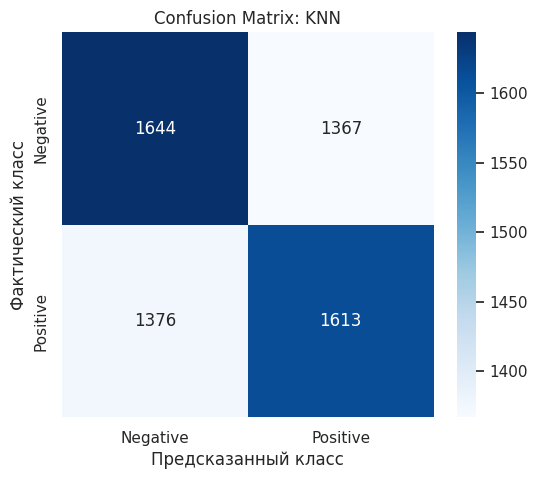

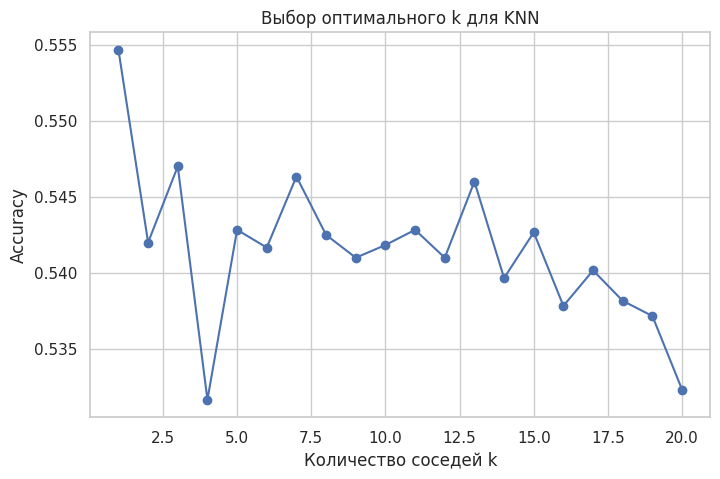

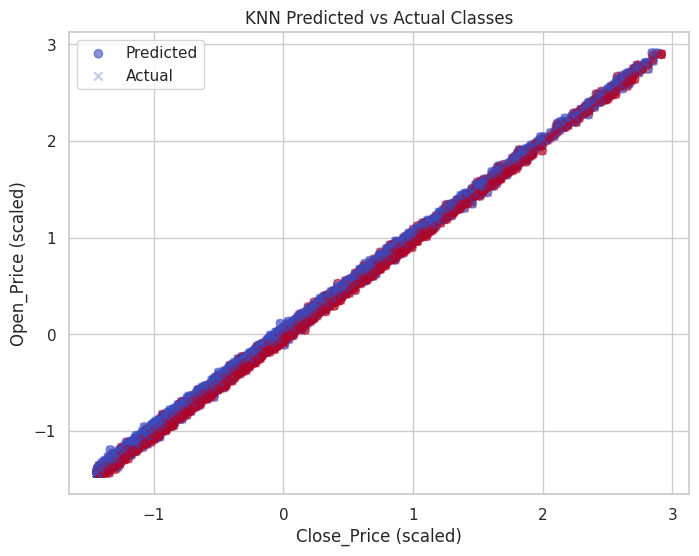

In [34]:
# Целевая переменная (направление доходности)
df['Return_Direction'] = (df['Daily_Return_Pct'] > 0).astype(int)

# Признаки для модели (топ-5 для компактности)
top_features = ['Close_Price', 'Open_Price', 'High_Price', 'Volatility_Range', 'Sentiment_Score']
X = df[top_features]
y = df['Return_Direction']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Обучение модели KNN (k=5)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Прогноз
y_pred = knn_model.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Визуализация 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Confusion Matrix: KNN')
plt.show()

# Визуализация 2: Accuracy vs k
accuracies = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_k_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_k_pred))

plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Количество соседей k')
plt.ylabel('Accuracy')
plt.title('Выбор оптимального k для KNN')
plt.grid(True)
plt.show()

# Визуализация 3: Предсказания vs фактические классы в 2D
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, cmap='coolwarm', alpha=0.6, label='Predicted')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', marker='x', alpha=0.3, label='Actual')
plt.xlabel('Close_Price (scaled)')
plt.ylabel('Open_Price (scaled)')
plt.title('KNN Predicted vs Actual Classes')
plt.legend()
plt.show()


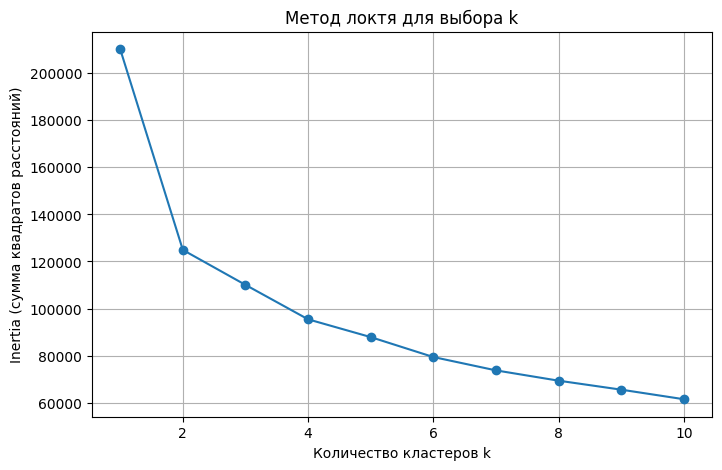

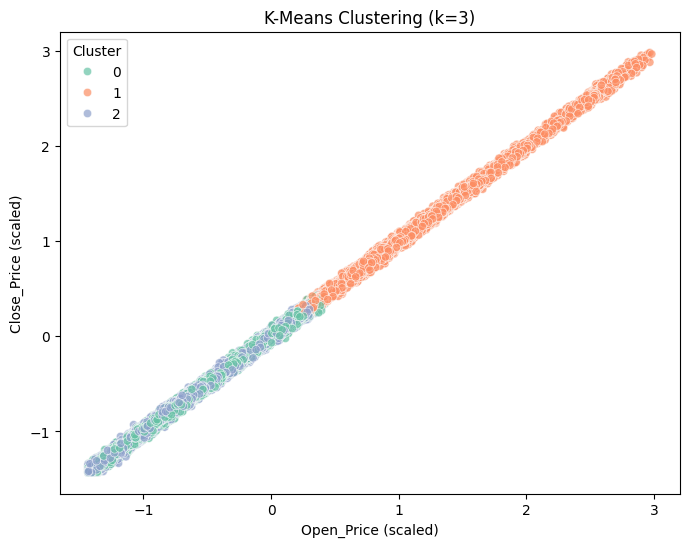

Средние значения признаков по кластерам:
         Open_Price  Close_Price  High_Price  Low_Price        Volume  \
Cluster                                                                 
0         25.531101    25.520835   26.712092  24.352044  1.004595e+07   
1         77.429597    77.426533   78.628278  76.242273  1.001709e+07   
2         25.257148    25.263121   26.452280  24.074642  1.006658e+07   

         Volatility_Range  Sentiment_Score  
Cluster                                     
0                2.368497        -0.514326  
1                2.386004        -0.000890  
2                2.387746         0.505782  


In [10]:
# Выбираем признаки для кластеризации
features = ['Open_Price', 'Close_Price', 'High_Price', 'Low_Price',
            'Volume', 'Volatility_Range', 'Sentiment_Score']
X = df[features]

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Определяем оптимальное число кластеров методом локтя
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia (сумма квадратов расстояний)')
plt.title('Метод локтя для выбора k')
plt.grid(True)
plt.show()

# Обучаем K-Means с выбранным k (например, k=3)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Визуализация кластеров в 2D (по двум ключевым признакам)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=df['Cluster'], palette='Set2', alpha=0.7)
plt.xlabel('Open_Price (scaled)')
plt.ylabel('Close_Price (scaled)')
plt.title(f'K-Means Clustering (k={k_opt})')
plt.legend(title='Cluster')
plt.show()

# Статистика по кластерам
cluster_stats = df.groupby('Cluster')[features].mean()
print("Средние значения признаков по кластерам:")
print(cluster_stats)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5129 - loss: 0.6959 - val_accuracy: 0.5125 - val_loss: 0.6921
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5241 - loss: 0.6921 - val_accuracy: 0.5246 - val_loss: 0.6916
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5320 - loss: 0.6911 - val_accuracy: 0.5456 - val_loss: 0.6889
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5487 - loss: 0.6889 - val_accuracy: 0.5827 - val_loss: 0.6858
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5866 - loss: 0.6846 - val_accuracy: 0.6185 - val_loss: 0.6784
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6276 - loss: 0.6753 - val_accuracy: 0.7017 - val_loss: 0.6599
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6953 - loss: 0.6531 - val_accuracy: 0.8154 - val_loss: 0.6205
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7959 - loss: 0.6045 - val_accuracy: 0.

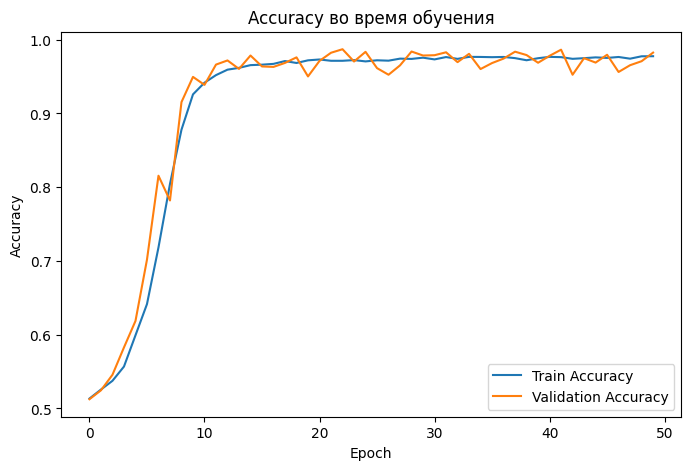

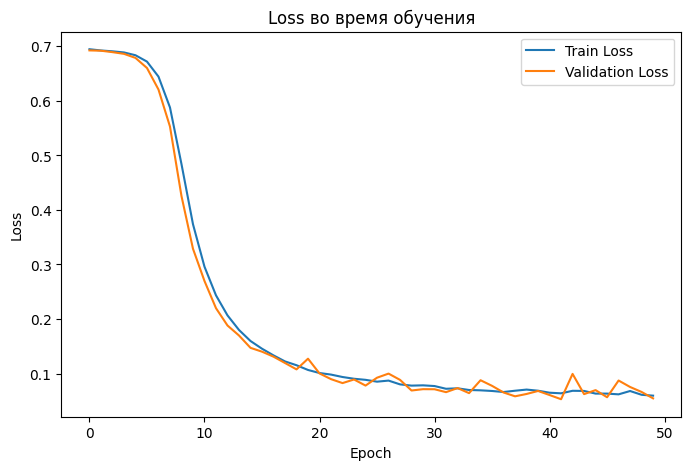

In [12]:
# Целевая переменная (направление доходности)
df['Return_Direction'] = (df['Daily_Return_Pct'] > 0).astype(int)

# Признаки для модели (топ-5 для компактности)
top_features = ['Close_Price', 'Open_Price', 'High_Price', 'Volatility_Range', 'Sentiment_Score']
X = df[top_features]
y = df['Return_Direction']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Создание модели нейронной сети
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # бинарная классификация

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Прогноз и метрики
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Визуализация процесса обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy во время обучения')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss во время обучения')
plt.legend()
plt.show()
